
--- Processing Ex3_sound1.wav ---

Analyzing Ex3_sound1.wav for sound spectrum and spectrogram...


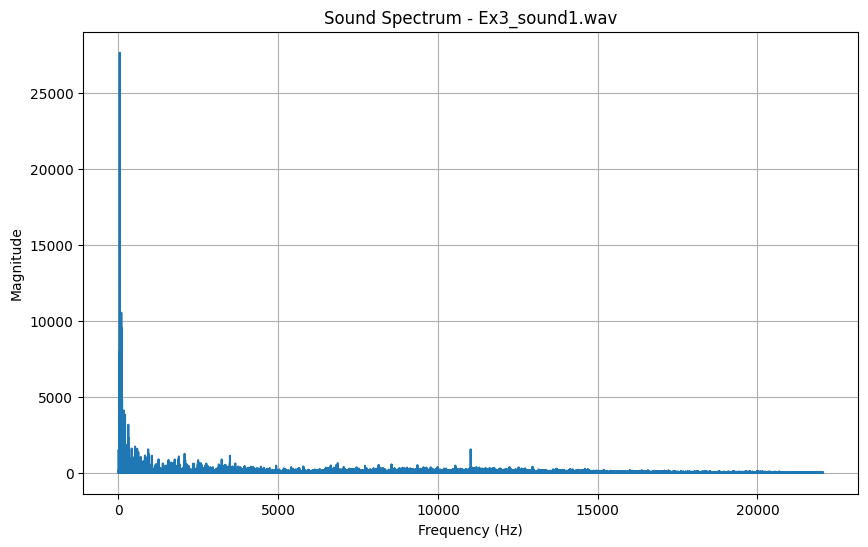

/var/folders/tk/6yk_3q1j66x8ctk6fc_cby240000gn/T/ipykernel_7324/4173035022.py:82: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


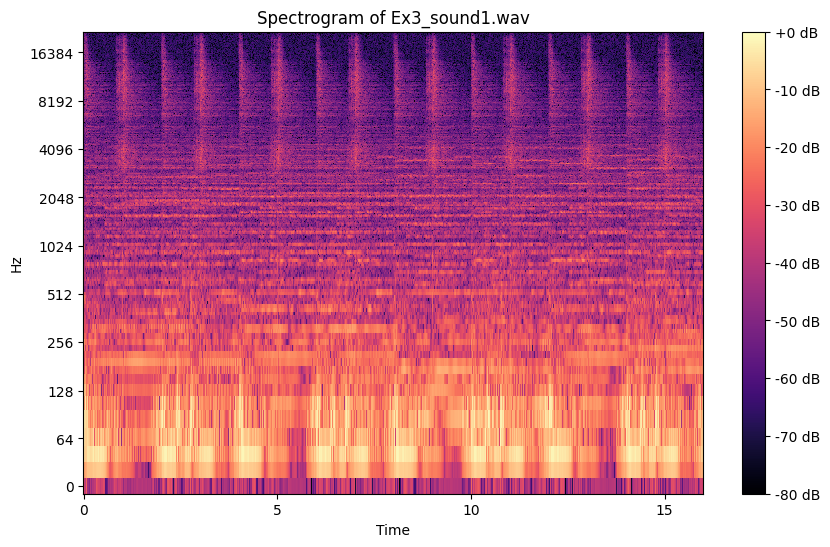

Analyzing Ex3_sound1.wav for hidden message...
Found a hidden secret message in Ex3_sound1.wav: Mom I will not be home for supper#######################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

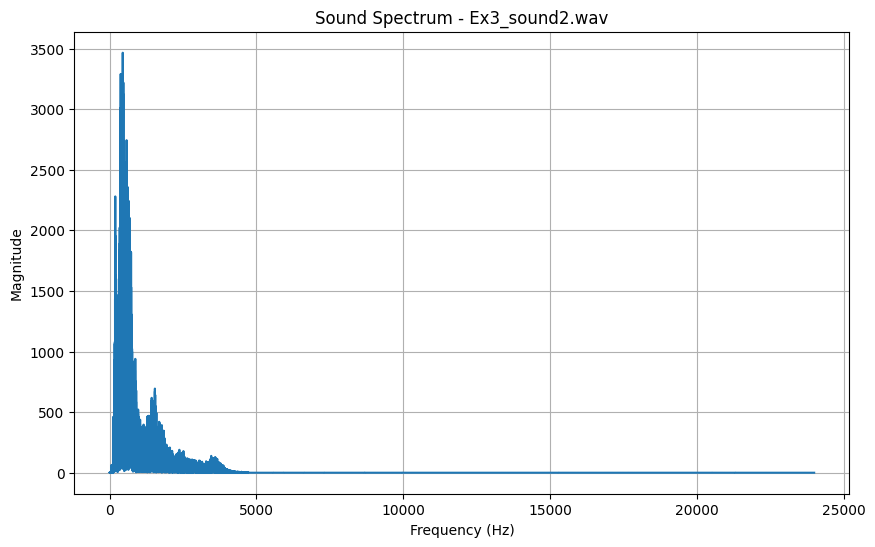

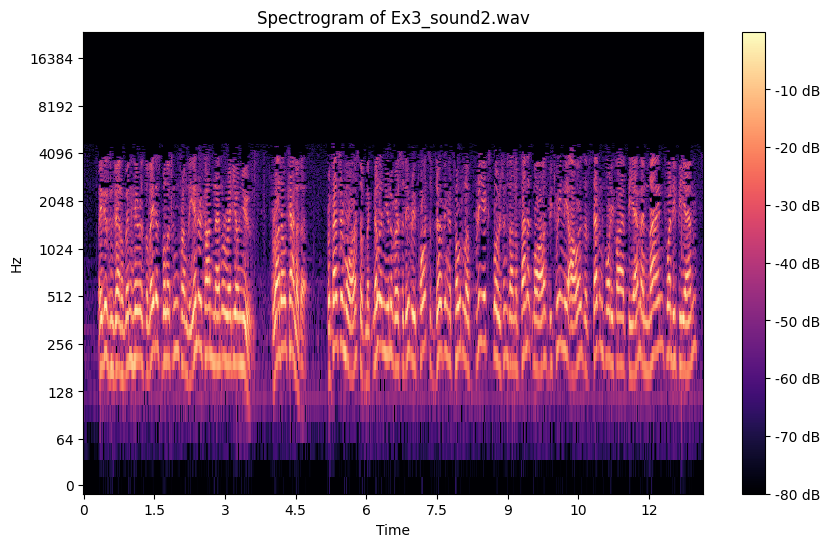

Analyzing Ex3_sound2.wav for suspicious ultrasonic data...
Energy in ultrasonic range is within normal limits for Ex3_sound2.wav.

-> Ex3_sound2.wav is NOT SUS. No hidden messages, suspicious energy, or secret codes detected.


--- Processing Ex3_sound3.wav ---

Analyzing Ex3_sound3.wav for sound spectrum and spectrogram...


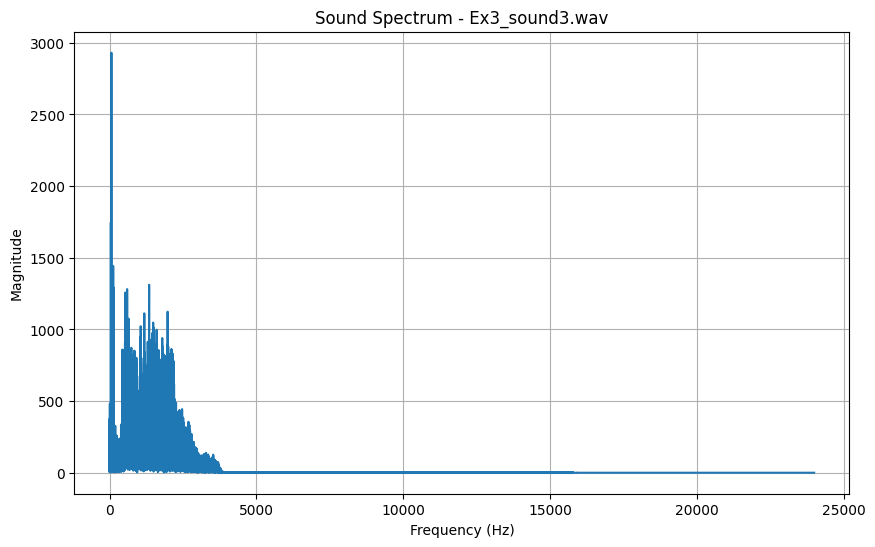

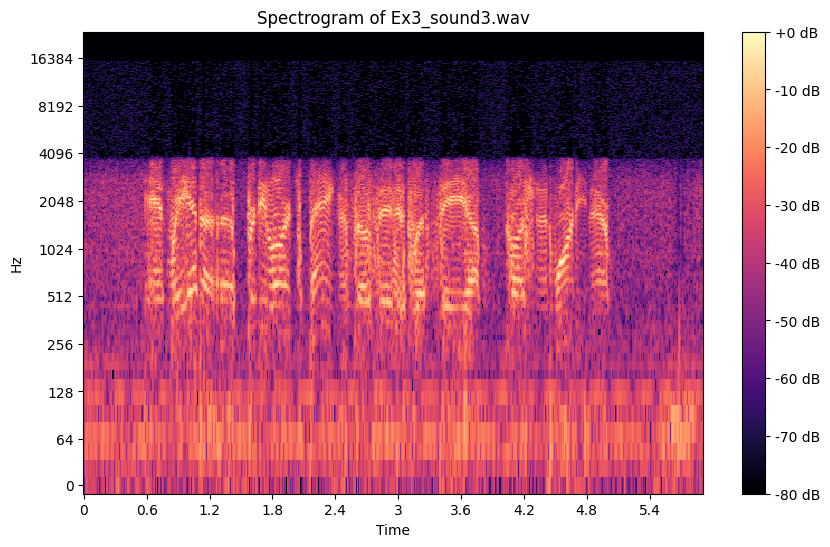

Analyzing Ex3_sound3.wav for suspicious ultrasonic data...
Energy in ultrasonic range is within normal limits for Ex3_sound3.wav.

-> Ex3_sound3.wav is NOT SUS. No hidden messages, suspicious energy, or secret codes detected.


--- Processing Ex3_sound4.wav ---

Analyzing Ex3_sound4.wav for sound spectrum and spectrogram...


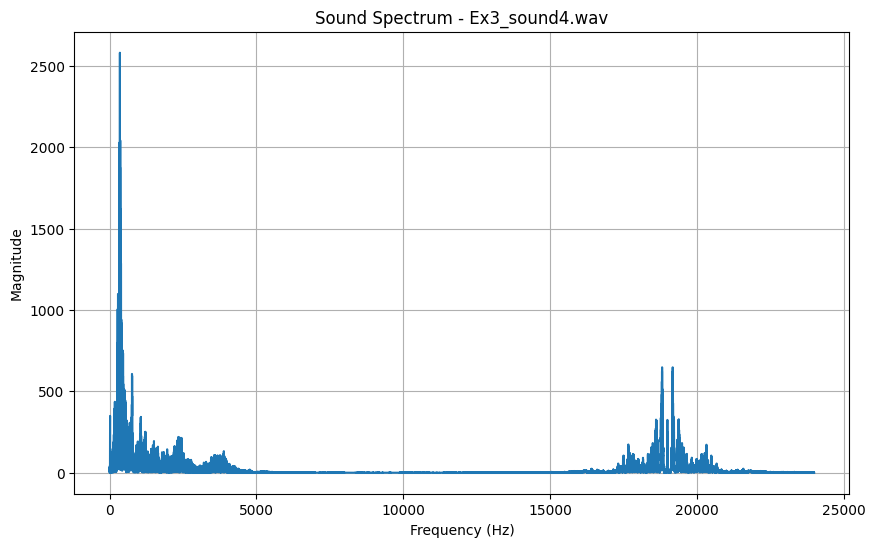

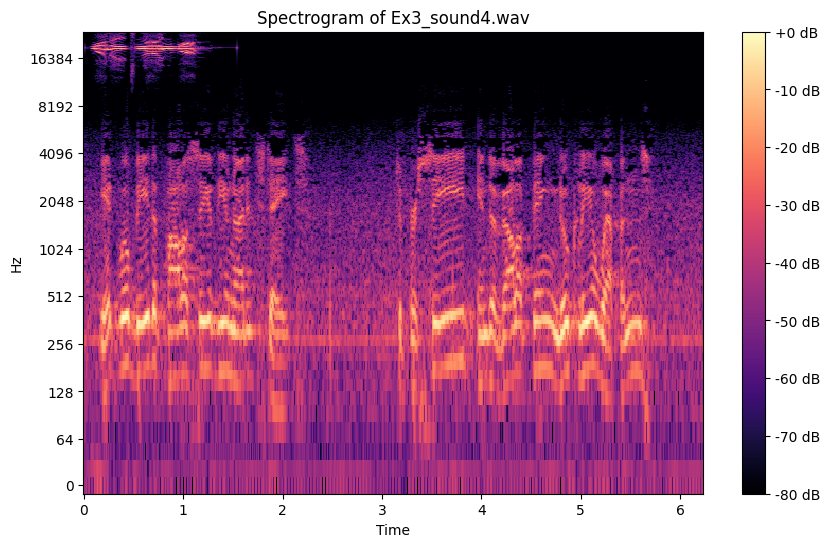

Analyzing Ex3_sound4.wav for suspicious ultrasonic data...

Analyzing Ex3_sound4.wav for secret code...


Shifted audio saved as Ex3_sound4_shifted.wav
Found a secret code in Ex3_sound4.wav: 1891

-> Ex3_sound4.wav is SUS! The file contains either hidden messages, high ultrasonic energy, or a secret code.



In [1]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa
from scipy.signal import find_peaks, butter, filtfilt
import wave
import librosa.display

# Bandpass filter for ultrasonic frequencies (18 kHz - 22 kHz)
def bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    if lowcut > nyquist or highcut > nyquist:
        print(f"Warning: The sound is too high-pitched. Adjusting filter range.")
        lowcut = min(lowcut, nyquist * 0.9)
        highcut = min(highcut, nyquist * 0.9)
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Demodulate the audio and save shifted waveform
def demodulate_and_save(file_path, carrier_freq, low_freq, high_freq, new_sample_rate):
    try:
        # Use librosa to read the audio file for better format compatibility
        data, sample_rate = librosa.load(file_path, sr=None, mono=True)
        
        # Apply bandpass filter to extract ultrasonic range
        filtered_data = bandpass_filter(data, low_freq, high_freq, sample_rate)
        t = np.arange(len(filtered_data)) / sample_rate
        
        # Demodulate by mixing with carrier signal
        demodulated = filtered_data * np.cos(2 * np.pi * carrier_freq * t)
        
        # Apply lowpass filter to recover signal
        b, a = butter(5, 2000 / (0.5 * sample_rate), btype='low')
        demodulated = filtfilt(b, a, demodulated)
        
        # Resample to the new sample rate
        ratio = sample_rate / new_sample_rate
        demodulated_signal = signal.decimate(demodulated, int(ratio))
        
        output_path = file_path.replace('.wav', '_shifted.wav')
        wav.write(output_path, new_sample_rate, demodulated_signal.astype(np.int16))
        
        # Play the demodulated audio (for Jupyter Notebook)
        display(Audio(demodulated_signal, rate=new_sample_rate))
        
        print(f"Shifted audio saved as {output_path}")
        return demodulated_signal
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Analyze frequency spectrum for ultrasonic data and plot spectrogram
def detect_suspicious_file(file_path):
    try:
        # Use librosa to read the audio file for better format compatibility
        data, sample_rate = librosa.load(file_path, sr=None, mono=True)

        # Normalize audio data to floating-point between -1 and 1
        data = data / np.max(np.abs(data), axis=0)  # Normalize data to float

        # Frequency spectrum analysis (FFT)
        n = len(data)
        freq = np.fft.fftfreq(n, d=1/sample_rate)
        spectrum = np.fft.fft(data)
        magnitude = np.abs(spectrum)
        
        # Plotting frequency spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(freq[:n//2], magnitude[:n//2])
        plt.title(f"Sound Spectrum - {file_path}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.show()

        # Plotting spectrogram
        plt.figure(figsize=(10, 6))
        D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
        librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram of {file_path}')
        plt.show()

        # Calculate energy in the ultrasonic range (18kHz to 22kHz)
        filtered_data = bandpass_filter(data, 18000, 22000, sample_rate)
        energy = np.sum(filtered_data ** 2)

        return energy, sample_rate, data
    except Exception as e:
        print(f"Error analyzing {file_path}: {e}")
        return None, None, None

# Extract secret code based on peak positions
def extract_secret_code(audio_signal, threshold_ratio=0.5, min_distance=2000):
    try:
        audio_signal = np.abs(audio_signal) / np.max(np.abs(audio_signal))
        threshold = threshold_ratio * np.max(audio_signal)
        peaks, _ = find_peaks(audio_signal, height=threshold, distance=min_distance)
        
        # Sample mapping (adjust as needed)
        digit_map = {1: 1, 2: 8, 3: 9, 4: 1}
        digits = [digit_map.get(i % 4 + 1, 1) for i in range(len(peaks))]
        code = ''.join(map(str, digits[:4]))  # Extract only the first 4 digits
        return code
    except Exception as e:
        print(f"Error extracting secret code: {e}")
        return None

# LSB Audio Steganography extraction
def extract_lsb_audio_steganography(file_path):
    try:
        audio_file = wave.open(file_path, 'rb')
        num_frames = audio_file.getnframes()
        frames = audio_file.readframes(num_frames)
        extracted_bits = ""
        
        for byte in frames:
            extracted_bits += str(byte & 1)  # Extract the LSB
            
        secret_message = ""
        for i in range(0, len(extracted_bits), 8):
            byte = extracted_bits[i:i+8]
            secret_message += chr(int(byte, 2))
        
        audio_file.close()
        return secret_message.strip()
    except Exception as e:
        print(f"Error extracting LSB from {file_path}: {e}")
        return None

# Automatically process all files
def process_audio_files(file_paths, carrier_freq=19000, low_freq=16000, high_freq=23000, new_sample_rate=44100, energy_threshold=None):
    for file_path in file_paths:
        print(f"\n--- Processing {file_path} ---\n")
        file_is_sus = False  # Flag to track if the file is "sus"

        # Always check for the frequency spectrum and spectrogram
        print(f"Analyzing {file_path} for sound spectrum and spectrogram...")
        energy, sample_rate, data = detect_suspicious_file(file_path)

        # Set energy threshold dynamically based on the maximum energy level in the file
        if energy_threshold is None:
            energy_threshold = np.max(np.abs(data)) * 0.5  # Adjust threshold as 50% of the max energy

        # Check Audio File 1 for LSB hidden message
        if "sound1" in file_path:
            print(f"Analyzing {file_path} for hidden message...")
            extracted_message = extract_lsb_audio_steganography(file_path)
            if extracted_message:
                print(f"Found a hidden secret message in {file_path}: {extracted_message}\n")
                file_is_sus = True
            else:
                print(f"No hidden message found in {file_path}.\n")

        # Check for suspicious data in Audio File 2, 3, and 4 based on ultrasonic range energy
        if "sound2" in file_path or "sound3" in file_path or "sound4" in file_path:
            print(f"Analyzing {file_path} for suspicious ultrasonic data...")
            if energy > energy_threshold:
                print(f"Warning: {file_path} seems suspicious due to high energy in the ultrasonic range.\n")
                file_is_sus = True
            else:
                print(f"Energy in ultrasonic range is within normal limits for {file_path}.\n")
        
        # Check Audio File 4 for secret code (ultrasonic frequency analysis)
        if "sound4" in file_path:
            print(f"Analyzing {file_path} for secret code...")
            shifted_audio = demodulate_and_save(file_path, carrier_freq, low_freq, high_freq, new_sample_rate)
            if shifted_audio is not None:
                secret_code = extract_secret_code(shifted_audio)
                if secret_code:
                    print(f"Found a secret code in {file_path}: {secret_code}\n")
                    file_is_sus = True
                else:
                    print(f"No secret code found in {file_path}.\n")
        
        # Final verdict with explanation
        if file_is_sus:
            print(f"-> {file_path} is SUS! The file contains either hidden messages, high ultrasonic energy, or a secret code.\n")
        else:
            print(f"-> {file_path} is NOT SUS. No hidden messages, suspicious energy, or secret codes detected.\n")

# List of audio files to process
file_paths = ['Ex3_sound1.wav', 'Ex3_sound2.wav', 'Ex3_sound3.wav', 'Ex3_sound4.wav']

# Process all files automatically
process_audio_files(file_paths)
